# Developing a Feature Space fo a MultiLabel CNN Model

### Imports:

In [1]:
import os
from sklearn.metrics import classification_report, jaccard_score, hamming_loss, accuracy_score
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from umap import UMAP
from keras import Model

In [ ]:
# Importing user-defined modules
from Scripts.pbtxl import *
from Scripts.cnn import *

### Loading and Preprocessing Data:

In [3]:
npz_file = r'Processed Datasets\processed_dataset_12_lead_lr.npz'

In [4]:
ptbxl, signals = load_database(npz_file)

In [5]:
ptbxl[:10]

,patient_id,age,sex,height,weight,site,device,strat_fold,scp_codes,filename_lr,superclasses,fields
1,15709.0,56.0,1,NaN,63.0,0.0,CS-12 E,3,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",records100/00000/00001_lr,[NORM],"{'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'bas..."
2,13243.0,19.0,0,NaN,70.0,0.0,CS-12 E,2,"{'NORM': 80.0, 'SBRAD': 0.0}",records100/00000/00002_lr,[NORM],"{'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'bas..."
3,20372.0,37.0,1,NaN,69.0,0.0,CS-12 E,5,"{'NORM': 100.0, 'SR': 0.0}",records100/00000/00003_lr,[NORM],"{'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'bas..."
4,17014.0,24.0,0,NaN,82.0,0.0,CS-12 E,3,"{'NORM': 100.0, 'SR': 0.0}",records100/00000/00004_lr,[NORM],"{'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'bas..."
5,17448.0,19.0,1,NaN,70.0,0.0,CS-12 E,4,"{'NORM': 100.0, 'SR': 0.0}",records100/00000/00005_lr,[NORM],"{'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'bas..."
6,19005.0,18.0,1,NaN,58.0,0.0,CS-12 E,4,"{'NORM': 100.0, 'SR': 0.0}",records100/00000/00006_lr,[NORM],"{'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'bas..."
7,16193.0,54.0,0,NaN,83.0,0.0,CS-12 E,7,"{'NORM': 100.0, 'SR': 0.0}",records100/00000/00007_lr,[NORM],"{'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'bas..."
8,11275.0,48.0,0,NaN,95.0,0.0,CS-12 E,9,"{'IMI': 35.0, 'ABQRS': 0.0, 'SR': 0.0}",records100/00000/00008_lr,[MI],"{'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'bas..."
9,18792.0,55.0,0,NaN,70.0,0.0,CS-12 E,10,"{'NORM': 100.0, 'SR': 0.0}",records100/00000/00009_lr,[NORM],"{'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'bas..."
10,9456.0,22.0,1,NaN,56.0,0.0,CS-12 E,9,"{'NORM': 100.0, 'SR': 0.0}",records100/00000/00010_lr,[NORM],"{'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'bas..."


In [6]:
signals.shape

(21388, 1000, 12)

In [7]:
# Formatting signals and superclassses
X = signals
Y = ptbxl.loc[:, ['strat_fold', 'superclasses']]

In [8]:
# Training set
x_train = X[(Y.strat_fold < 9)]
y_train = Y[(Y.strat_fold < 9)].superclasses

In [9]:
# Tesing set
x_test = X[(Y.strat_fold >= 9)]
y_test = Y[(Y.strat_fold >= 9)].superclasses

In [10]:
# Converting labels into binary matrix format
y_train, y_test, class_labels = ml_label_encoding(y_train, y_test)

In [11]:
print('X Train:', x_train.shape)
print('Y Train:', y_train.shape)
print('X Test:', x_test.shape)
print('Y Test:', y_test.shape)

X Train: (17084, 1000, 12)
Y Train: (17084, 5)
X Test: (4304, 1000, 12)
Y Test: (4304, 5)


In [12]:
# Creating a mapping to keep track of a signal's original ECG ID
x_train_mapping = pd.Series(data=y_train.index, index=range(len(x_train)), name='ecg_id')
x_test_mapping = pd.Series(data=y_test.index, index=range(len(x_test)), name='ecg_id')

In [13]:
x_train_mapping

0            1
1            2
2            3
3            4
4            5
         ...  
17079    21832
17080    21833
17081    21834
17082    21835
17083    21836
Name: ecg_id, Length: 17084, dtype: int64

In [14]:
x_test_mapping

0           8
1           9
2          10
3          26
4          28
        ...  
4299    21818
4300    21819
4301    21826
4302    21831
4303    21837
Name: ecg_id, Length: 4304, dtype: int64

### Loading Model and Extracting Features:

In [15]:
def load_model(checkpoint_path: str, model_type: str='a') -> keras.Sequential:
    '''
    Loads and returns a CNN model using pre-defined weights. The model generated and compiled is determined by the model 
    architecture specified for the 'model_type' argument.
    
    Args:
        checkpoint_path: The path containing the pre-definded weights
        model_type: The type of model architecture to compile
        
    Returns:
        keras.Sequential: The compiled model
    '''
    # Generates a model using the article architecture
    if model_type == 'a':
        model = generate_article_1D_model()
    
    elif model_type == 'c':
        model = generate_12lead_model()
    
    # Loads best weights from training session
    model.load_weights(checkpoint_path)
    
    # Compiles model with similar hyperparametes as pre-trained model
    model.compile(loss = keras.losses.BinaryCrossentropy(),
                  optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
                  metrics = [keras.metrics.BinaryAccuracy(name='Accuracy'),
                             keras.metrics.Recall(name='Recall'),
                             keras.metrics.Precision(name='Precision'),
                             keras.metrics.AUC(name='AUC')])
    
    return model

In [16]:
def extract_features(checkpoint_path: str, x_test: pd.DataFrame | np.ndarray, model_type: str='a', show_summary: bool=True) -> np.ndarray:
    '''
    Extracts feature representations of a pre-trained model using validation data. The output (final) layer is removed from the 
    model in order to return the feature embeddings from the penultimate layer.
    
    Args:
        checkpoint_path: The path containing the weights to load into the generated model
        x_test: DataFrame containing the ECG signals corresponding to the testing/validation set
        model_type: Specifies which model architecture to load
        show_summary: Boolean value that determines if the new model architecture will be displayed
        
    Returns:
        np.ndarray: A matrix containing feature embeddings from the penultimate layer
    '''
    # Loading model of specified architecture
    model = load_model(checkpoint_path=checkpoint_path, model_type=model_type)
    
    # Removing the final layer and printing architecture of the model
    model.pop()
    
    if show_summary:
        model.summary()
   
    # Predicts and extracts the features
    feature_embeddings = model.predict(x_test)
    
    return feature_embeddings

In [17]:
# Model with article architecture
checkpoint_path = r'training_sessions\session_7\weights\CustomCNN_12Lead_96.weights.h5'

In [18]:
feature_embeddings = extract_features(checkpoint_path, x_test, model_type='c')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1000, 36)       │           540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1000, 36)       │           144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1000, 36)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000, 36)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 500, 64)        │        16,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 500, 128)       │        57,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 500, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 250, 128)       │        81,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 250, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 250, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 250, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 250, 256)       │       163,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 250, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 250, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 250, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,89

 Total params: 355,116 (1.35 MB)

 Trainable params: 353,892 (1.35 MB)

 Non-trainable params: 1,224 (4.78 KB)

135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step


### Generating Predictions:

In [19]:
# Loading new model with complete article architecture
model_1 = load_model(checkpoint_path, model_type='c')

In [20]:
y_test, y_hat = model_predict(model=model_1, test_data=x_test, test_labels=y_test)

135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step


In [21]:
print('Predictions:\n')
y_hat

Predictions:



array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0]])

In [22]:
print('\nTrue Labels:\n')
y_test


True Labels:



,0,1,2,3,4
8,0,0,1,0,0
9,0,0,0,1,0
10,0,0,0,1,0
26,0,0,0,0,1
28,0,0,0,0,1
...,...,...,...,...,...
21818,0,0,0,1,0
21819,1,0,0,0,0
21826,0,0,1,0,0
21831,0,0,0,1,0


### Computing Confusion Matrix:

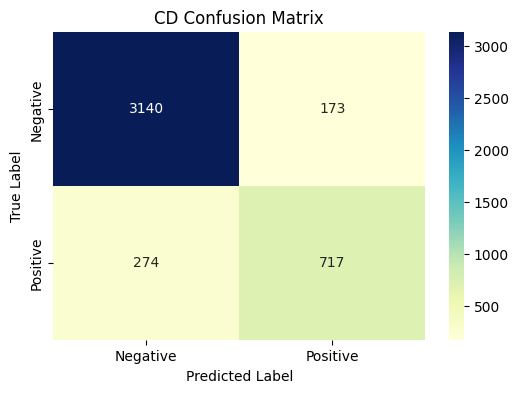

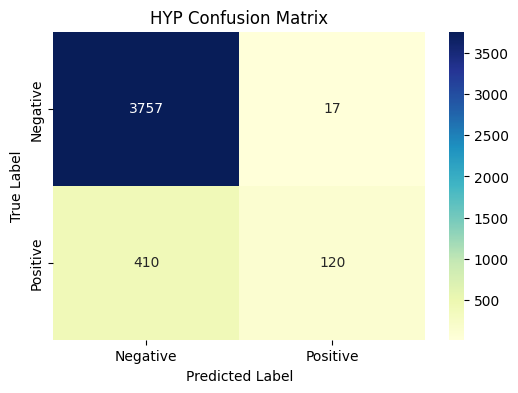

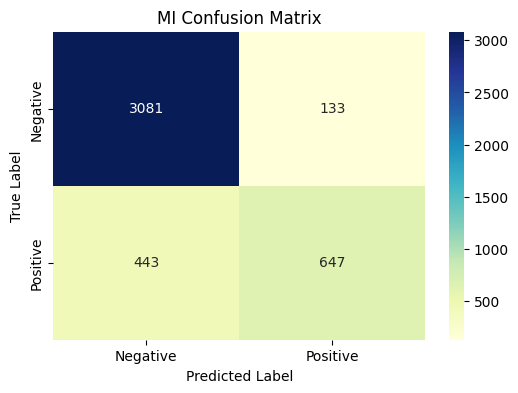

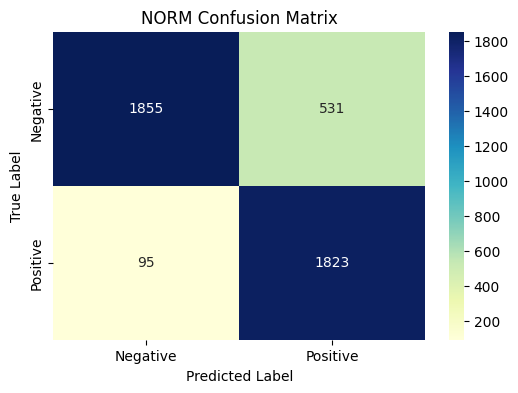

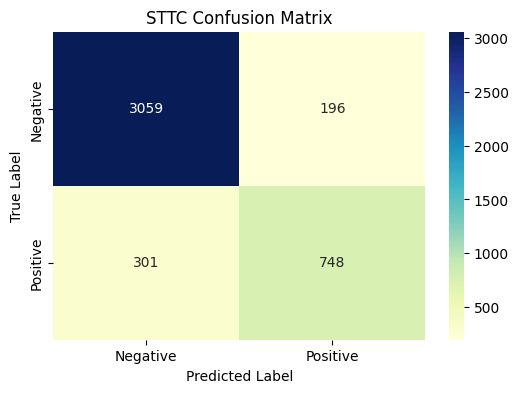

In [23]:
conf_matrix = show_confusion_matrix(y_test, y_hat, classes=class_labels) 

### Computing Classification Report:

In [24]:
print(classification_report(y_test, y_hat, target_names=class_labels))

              precision    recall  f1-score   support

          CD       0.81      0.72      0.76       991
         HYP       0.88      0.23      0.36       530
          MI       0.83      0.59      0.69      1090
        NORM       0.77      0.95      0.85      1918
        STTC       0.79      0.71      0.75      1049

   micro avg       0.79      0.73      0.76      5578
   macro avg       0.82      0.64      0.68      5578
weighted avg       0.80      0.73      0.74      5578
 samples avg       0.79      0.76      0.76      5578



c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Class K-Means Clustering:

In [25]:
def display_class_clusters(feature_embeddings: np.ndarray, dim_red: str='p') -> np.ndarray:
    '''
    Returns clustered superclasses from the PTB-XL database based on the feature embeddings provided. 
    Clusters are computed via K-Means clustering.
    
    Args:
        feature_embeddings: The feature embeddings to be clustered
        dim_red: The dimensionality reduction to use when visualing clusters ('p'= PCA, 't'= TSNE, 'u'= UMAP)
        
    Returns:
        np.ndarray: An array containing the assigned cluster label for each record/data point
    '''
    # Grouping extracted features into clusters and storing associated labels for all records
    kmeans = KMeans(n_clusters=5, random_state=42).fit(feature_embeddings)
    labels = kmeans.labels_
    
    # Organzing data into a DataFrame
    clusters = pd.DataFrame(data=labels, columns=['Cluster'])
    
    # Reducing data to two-dimensional feature space using the specified reduction technique
    if dim_red == 'p':
        pca = PCA(n_components=2, random_state=42)
        data = pca.fit_transform(feature_embeddings)
        col_names = ['pca1', 'pca2']
        
    elif dim_red == 't':
        tsne = TSNE(n_components=2, random_state=42)
        data = tsne.fit_transform(feature_embeddings)
        col_names = ['tsne1', 'tsne2']
    
    elif dim_red == 'u':    
        umap = UMAP(n_components=2, random_state=42)
        data = umap.fit_transform(feature_embeddings)
        col_names = ['umap1', 'umap2']

    # Storing reduced data into a DataFrame and plotting the clusters
    results = pd.DataFrame(data=data, columns=col_names) 
    sns.scatterplot(x=col_names[0],
                    y=col_names[1],
                    hue=clusters['Cluster'],
                    data=results)
    
    plt.title('K-Means Clusters')
    plt.show()
    return labels

c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


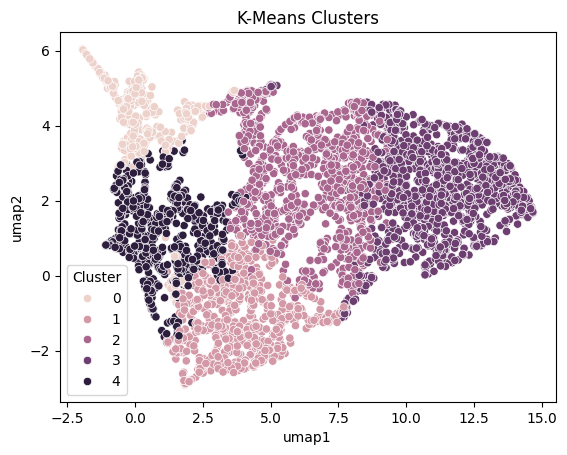

In [26]:
class_cluster_labels = display_class_clusters(feature_embeddings, dim_red='u')

In [27]:
def get_class_cluster_accuracy(test_labels: pd.DataFrame | pd.Series | np.ndarray, cluster_labels: np.ndarray, n_classes: int) -> dict:
    '''
    Determines the accuracy between the ground truth labels and the assigned cluster labels using a two-method approach. The first
    method creates prototypical vectors for each cluster. These vectors are averaged and binarized to represent the most prominent
    classes found within a cluster. This vector-class mapping is then utilized for the second method. The second method computes an 
    exact match score, a Jaccard score, and the Hamming loss. Confusion matrices are then used to determine the best class-cluster pair.
    
    Args:
        test_labels: Ground truth labels of shape (n_samples, n_classes)
        cluster_labels: An array containing cluster label assignments
        n_classes: The number of unique classes within the test labels
        
    Returns:
        dict: A dictionary containing various metrics (e.g., exact match score (clustering accuracy),
        Jaccard Score, and Hamming Loss)
    '''
    # Method 1: Prototypical vectors for each cluster
    n_clusters = len(np.unique(cluster_labels))
    
    # Creating zero-array to hold prototypical vectors for each cluster
    if n_classes > 2:
        cluster_vectors = np.zeros((n_clusters, n_classes))
    else:
        cluster_vectors = np.zeros((n_clusters, 1))
        
    for cluster_id in range(n_clusters):
        # Creating boolean mask for current cluster
        cluster_mask = cluster_labels == cluster_id
        cluster_data = test_labels[cluster_mask]
        cluster_data = cluster_data.astype(int)
        
        # Averaging data to get singular vector representation of current cluster
        if len(cluster_data) > 0:
            cluster_vectors[cluster_id] = np.mean(cluster_data, axis=0)
        
    # Binarizing vector to keep most prominent labels/classes
    cluster_vectors = (cluster_vectors >= 0.5).astype(int)

    # Generating predictions based on vector-label mapping
    predictions = cluster_vectors[cluster_labels]
            
    # Method 2: Per-class best cluster mapping
    per_class_mappings = {}
    per_class_accuracies = {}
    
    for class_idx in range(n_classes):
        
        # Retrieving binary class labels (i.e., 0 or 1) for current class
        if (n_classes > 2 ) and (isinstance(test_labels, (np.ndarray, pd.DataFrame))):
            if isinstance(test_labels, np.ndarray):
                binary_class_labels = test_labels[:, class_idx]
            elif isinstance(test_labels, pd.DataFrame):
                binary_class_labels = test_labels.iloc[:, class_idx]
        else:
            binary_class_labels = (test_labels == class_idx).astype(int)
        
        class_conf_matrices = []
        
        for cluster_id in range(n_clusters):
            # Retrieving binary cluster labels (i.e., 0 or 1) for current cluster
            binary_cluster_labels = (cluster_labels == cluster_id).astype(int)
            
            # Creating a 2x2 matrix for current class and cluster
            tn = np.sum((binary_class_labels == 0) & (binary_cluster_labels == 0))
            fp = np.sum((binary_class_labels == 0) & (binary_cluster_labels == 1))
            fn = np.sum((binary_class_labels == 1) & (binary_cluster_labels == 0))
            tp = np.sum((binary_class_labels == 1) & (binary_cluster_labels == 1))
            
            # Storing positive assignment scores (i.e., true positives and true negatives)
            class_conf_matrices.append(tp + tn)
        
        # Determining the best cluster-class pair  
        best_cluster_idx = np.argmax(class_conf_matrices)
        per_class_mappings[f'Class {class_idx}'] = best_cluster_idx
        per_class_accuracies[f'Class {class_idx}'] = (class_conf_matrices[best_cluster_idx] / len(test_labels))
            
    # Calculating Jaccard score and Hamming loss
    jaccard = jaccard_score(test_labels, predictions, average='macro')
    hamming = hamming_loss(test_labels, predictions)
    
    # Calculating exact match accuracy
    if n_classes > 2:
        exact_match_array = np.all(test_labels == predictions, axis=1)
    else:
        exact_match_array = (test_labels == predictions.flatten())

    exact_match_score = np.mean(exact_match_array)
    
    results = {'cluster_vectors': cluster_vectors,
               'per_class_best_cluster': per_class_mappings,
               'per_class_accuracies': per_class_accuracies,
               'exact_match_accuracy': exact_match_score,
               'jaccard_score': jaccard,
               'hamming_loss': hamming,
               'predictions': predictions}
    
    print(f'Clustering Accuracy: {exact_match_score:.2%}')
    print('Per-Class Best Clusters:', per_class_mappings)
    print(f'Jaccard Score: {jaccard:.2f}')
    print(f'Hamming Loss: {hamming:.2f}')
    
    return results

In [28]:
# Determining clustering accuracy for superclass labels
class_cluster_acc = get_class_cluster_accuracy(y_test, class_cluster_labels, n_classes=len(class_labels))

Clustering Accuracy: 59.18%
Per-Class Best Clusters: {'Class 0': 0, 'Class 1': 0, 'Class 2': 4, 'Class 3': 3, 'Class 4': 1}
Jaccard Score: 0.42
Hamming Loss: 0.14


### Extracting Metadata Featues:

In [29]:
def get_metadata_feature(ptbxl_database: pd.DataFrame, train_labels: pd.DataFrame, test_labels: pd.DataFrame, feature: str, remove_na: bool=True, min_threshold: int | None=None, max_threshold: int | None=None) -> tuple[pd.Series, pd.Series]:
    '''
    Retrieves a specific feature from the PTB-XL database and returns both training and testing labels as Pandas Series. Removes any missing 
    values by default and can additionally remove any values below or above a specified threshold.
    
    Args:
        ptbxl_database: The DataFrame containing all the PTB-XL metadata
        train_labels: The ECG labels corresponding to the training set
        test_data: The ECG labels corresponding to the test set
        feature: The feature/attribute within 'ptbxl_database' that is being retrieved (e.g., age, height)
        remove_na: Boolean value that determines if missing values will be removed
        min_threshold: If specified, removes any records holding a value less than the threshold
        max_threshold: If specified, removes any records holding a value larger than the threshold
        
    Returns:
        tuple: A two-element tuple (training and testing set) containing the labels for the specified feature

    '''
    y_train = train_labels
    y_test = test_labels
    
    # Retrieving record indices corresponding to both training and validation datasets
    y_train_indices = y_train.index
    y_test_indices = y_test.index
    
    # Acquiring labels corresponding to specified feature
    feat_y_train = ptbxl_database.loc[y_train_indices, feature].convert_dtypes()
    feat_y_test = ptbxl_database.loc[y_test_indices, feature].convert_dtypes()
    
    if remove_na:
        # Finding empty records
        na_y_train = pd.isna(feat_y_train)
        na_y_test = pd.isna(feat_y_test)
        
        # Keeping non-empty records
        feat_y_train = feat_y_train[~(na_y_train)]
        feat_y_test = feat_y_test[~(na_y_test)]
        
        na_y_train_count = na_y_train.sum()
        na_y_test_count = na_y_test.sum()
        
    if min_threshold:
        if remove_na:
            # Finding values below minimum threshold
            y_train_mask = (feat_y_train >= min_threshold)
            y_test_mask = (feat_y_test >= min_threshold)
 
            # Removing values below minimum threshold           
            feat_y_train = feat_y_train[y_train_mask]
            feat_y_test = feat_y_test[y_test_mask]
            
            min_y_train_count = (~y_train_mask).sum()
            min_y_test_count = (~y_test_mask).sum()
            
        else:
            feat_y_train.loc[feat_y_train < min_threshold] = np.nan
            feat_y_test.loc[feat_y_test < min_threshold] = np.nan
    else:
        min_y_train_count = 0
        min_y_test_count = 0
        
    if max_threshold:
        if remove_na:
            # Finding values above maximum threshold
            y_train_mask = (feat_y_train <= min_threshold)
            y_test_mask = (feat_y_test <= min_threshold)
            
            # Removing values above maximum threshold
            feat_y_train = feat_y_train[y_train_mask]
            feat_y_test = feat_y_test[y_test_mask]
            
            max_y_train_count = (~y_train_mask).sum()
            max_y_test_count = (~y_test_mask).sum()
            
        else:
            feat_y_train.loc[feat_y_train > max_threshold] = np.nan
            feat_y_test.loc[feat_y_test > max_threshold] = np.nan
    else:
        max_y_train_count = 0
        max_y_test_count = 0
           
    if remove_na:
        print('Records Removed:\n')
        print(f'\t\tMissing Values\t\tBelow Min Thresh\tAbove Max Tresh')
        print(f'Train Set:\t{na_y_train_count:,}\t\t\t{min_y_train_count:,}\t\t\t{max_y_train_count:,}')
        print(f' Test Set:\t{na_y_test_count:,}\t\t\t{min_y_test_count:,}\t\t\t{max_y_test_count:,}')
        
        feat_y_train = pd.Series(data=feat_y_train, index=feat_y_train.index)
        feat_y_test = pd.Series(data=feat_y_test, index=feat_y_test.index)
    else:
        feat_y_train = pd.Series(data=feat_y_train, index=y_train.index)
        feat_y_test = pd.Series(data=feat_y_test, index=y_test.index)
    
    return (feat_y_train, feat_y_test)

In [30]:
# Retrieving age metadata
age_x_train, age_x_test = get_metadata_feature(
    ptbxl,
    train_labels=y_train,
    test_labels=y_test,
    feature='age',
    remove_na=False,
    min_threshold=2
)

In [31]:
# Retrieving sex metadata
sex_x_train, sex_x_test = get_metadata_feature(
    ptbxl,
    train_labels=y_train,
    test_labels=y_test,
    feature='sex',
    remove_na=False
)

In [32]:
# Retrieving height metadata
height_x_train, height_x_test = get_metadata_feature(
    ptbxl, 
    train_labels=y_train,
    test_labels=y_test,
    feature='height',
    min_threshold=60,
    remove_na=False
)

In [33]:
# Retrieving weight metadata
weight_x_train, weight_x_test = get_metadata_feature(
    ptbxl,
    train_labels=y_train,
    test_labels=y_test,
    feature='weight',
    min_threshold=5,
    remove_na=False
)

### Binning Metadata to Create Discrete Labels:

In [34]:
def get_metadata_buckets(train_metadata: pd.DataFrame | pd.Series, test_metadata: pd.DataFrame | pd.Series, buckets: int | list) -> tuple[pd.Series, pd.Series, np.ndarray]:
    '''
    Groups metadata into ordered buckets (i.e. categorically labeled groups).
    
    Args:
        train_metadata: The DataFrame or Series holding the labels from the training set
        test_metadata: The DataFrame or Series holding the labels from the testing/validation set        
        buckets: As an integer, creates n equally sized buckets. As a list, uses list values as the ranges for each bucket
    
    Returns:
        Tuple: A three-element tuple containing: Training buckets, testing buckets, intervals used to create buckets
    '''
    if type(buckets) == int:
        # Creating training buckets
        train_buckets_df, train_bins = pd.cut(
            train_metadata,
            bins=buckets,
            labels=list(range(buckets)),
            retbins=True
        )
        
        # Creating testing buckets
        test_buckets_df = pd.cut(
            test_metadata,
            bins=train_bins,
            labels=list(range(buckets))
        )
        
    elif type(buckets) == list:
        # Creating training buckets
        train_buckets_df, train_bins = pd.cut(
            train_metadata,
            bins=buckets,
            labels=list(range(len(buckets) - 1)),
            retbins=True,
            include_lowest=True
        )
        
        # Creating testing buckets
        test_buckets_df = pd.cut(
            test_metadata,
            bins=buckets,
            labels=list(range(len(buckets) - 1)),
            include_lowest=True
        )
    
    # Printing bucket labels and their intervals
    print(f'Bucket Intervals:\n')
    for i in range((len(train_bins) - 1)):
        if i == 0:
            print(f'Bucket {i}: [{train_bins[i]:.2f}, {train_bins[i+1]:.2f}]')
        else:
            print(f'Bucket {i}: ({train_bins[i]}, {train_bins[i+1]}]')
                
    return (train_buckets_df, test_buckets_df, train_bins)

In [35]:
age_buckets = [2, 25, 50, 75, np.inf]
age_y_train, age_y_test, age_bucket_intervals = get_metadata_buckets(age_x_train, age_x_test, buckets=age_buckets)

Bucket Intervals:

Bucket 0: [2.00, 25.00]
Bucket 1: (25.0, 50.0]
Bucket 2: (50.0, 75.0]
Bucket 3: (75.0, inf]


In [36]:
sex_y_train, sex_y_test = ptbxl.loc[y_train.index, 'sex'].astype(int), ptbxl.loc[y_test.index, 'sex'].astype(int)

In [37]:
height_buckets = [60, 100, 133, 166, np.inf]
height_y_train, height_y_test, height_bucket_intervals = get_metadata_buckets(height_x_train, height_x_test, buckets=height_buckets)

Bucket Intervals:

Bucket 0: [60.00, 100.00]
Bucket 1: (100.0, 133.0]
Bucket 2: (133.0, 166.0]
Bucket 3: (166.0, inf]


In [38]:
weight_buckets = [5, 60, 120, 180, np.inf]
weight_y_train, weight_y_test, weight_bucket_intervals = get_metadata_buckets(weight_x_train, weight_x_test, buckets=weight_buckets)

Bucket Intervals:

Bucket 0: [5.00, 60.00]
Bucket 1: (60.0, 120.0]
Bucket 2: (120.0, 180.0]
Bucket 3: (180.0, inf]


### Creating Embeddings from Metadata-Specific Signal Data:

In [39]:
def get_na_mask(metadata: pd.Series) -> pd.Series:
    '''
    Creates a boolean mask for a metadata feature that will extract only non-empty records when applied to the original
    training and testing signals.
    
    Args:
        metadata: A specific feature's metadata
        
    Returns:
        pd.Series: A boolean mask to keep only non-empty records when applied to the training or testing signals
    '''
    mask = ~(metadata.isna())
    mask = mask.reset_index(drop=True)
    return mask

In [40]:
age_train_mask = get_na_mask(age_x_train)
age_test_mask = get_na_mask(age_x_test)

# Updating the labels for age metadata
age_y_train = age_y_train[~(age_y_train.isna())]
age_y_test = age_y_test[~(age_y_test.isna())]

In [41]:
age_embeddings = extract_features(checkpoint_path, x_test[age_test_mask], model_type='c', show_summary=False)

135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step


In [42]:
sex_train_mask = get_na_mask(sex_x_train)
sex_test_mask = get_na_mask(sex_x_test)

# Updating the labels for sex metadata
sex_y_train = sex_y_train[~(sex_y_train.isna())]
sex_y_test = sex_y_test[~(sex_y_test.isna())]

In [43]:
sex_embeddings = extract_features(checkpoint_path, x_test[sex_test_mask], model_type='c', show_summary=False)

135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step


In [44]:
height_train_mask = get_na_mask(height_x_train)
height_test_mask = get_na_mask(height_x_test)

# Updating the labels for height metadata
height_y_train = height_y_train[~(height_y_train.isna())]
height_y_test = height_y_test[~(height_y_test.isna())]

In [45]:
height_embeddings = extract_features(checkpoint_path, x_test[height_test_mask], model_type='c', show_summary=False)

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


In [46]:
weight_train_mask = get_na_mask(weight_x_train)
weight_test_mask = get_na_mask(weight_x_test)

# Updating the labels for weight metadata
weight_y_train = weight_y_train[~(weight_y_train.isna())]
weight_y_test = weight_y_test[~(weight_y_test.isna())]

In [47]:
weight_embeddings = extract_features(checkpoint_path, x_test[weight_test_mask], model_type='c', show_summary=False)

68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


### Metadata K-Means Clustering:

In [48]:
def display_metadata_clusters(metadata: pd.Series, feature_embeddings: np.ndarray, bucket_intervals: np.ndarray | None=None, dim_red: str='u'):
    '''
    Clusters feature embeddings via K-Means using the number of buckets/groups found in the data. The provided metadata should be
    labeled according to its bucket group and consist of one of the features found within the PTB-XL database.
    
    Args:
        metadata: The metadata (e.g., age, height) that will be used to cross-check the clustered feature embeddings
        feature_embeddings: The feature embeddings that will be clustered
        bucket_intervals: An array containing the ranges of all buckets regarding the metadata
        dim_red: The dimensionality reduction to use when visualing clusters ('p'= PCA, 't'= TSNE, 'u'= UMAP)
        
    Returns:
        np.ndarray: An array containing the assigned cluster labels for each record/data point
    '''
    # Retrieving the number of clusters
    try:
        n_clusters = len(bucket_intervals) - 1
    except TypeError:
        n_clusters = 2
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(feature_embeddings)
    cluster_labels = kmeans.labels_
    
    # Reducing feature embeddings to a two-dimensional feature space using the specified reduction technique
    if dim_red == 'p':
        pca = PCA(n_components=2, random_state=42)
        data = pca.fit_transform(feature_embeddings)
        col_names = ['pca1', 'pca2']
        
    elif dim_red == 't':
        tsne = TSNE(n_components=2, random_state=42)
        data = tsne.fit_transform(feature_embeddings)
        col_names = ['tsne1', 'tsne2']
    
    elif dim_red == 'u':    
        umap = UMAP(n_components=2, random_state=42)
        data = umap.fit_transform(feature_embeddings)
        col_names = ['umap1', 'umap2']
    
    # Storing transformed data into a DataFrame and plotting the clusters
    column_name = metadata.name.capitalize()
   
    results = pd.DataFrame(data=data, columns=col_names)
    results[f'{column_name} Group'] = metadata.reset_index(drop=True)
    results['Cluster'] = cluster_labels
    
    sns.scatterplot(x=col_names[0],
                    y=col_names[1],
                    hue=results['Cluster'],
                    style=results[f'{column_name} Group'],
                    data=results)
    plt.title(f'K-Means Clusters vs. {column_name}')
    plt.show()
    
    return cluster_labels

c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


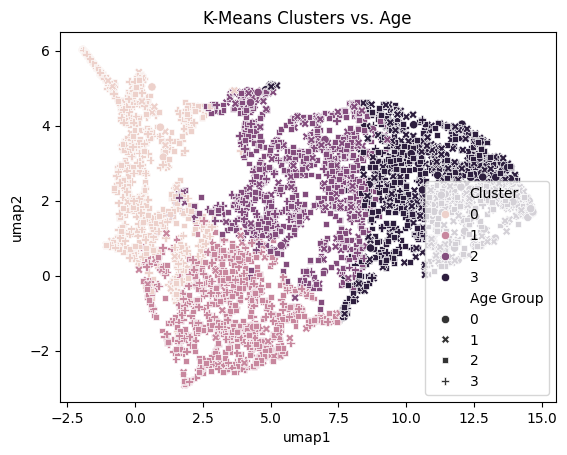

In [49]:
age_cluster_labels = display_metadata_clusters(age_y_test, age_embeddings, age_bucket_intervals)

c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


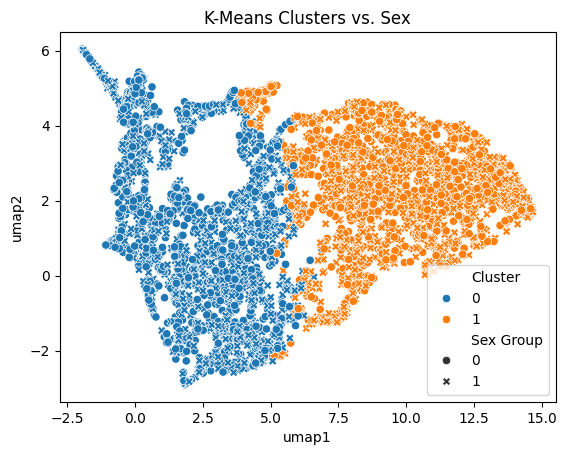

In [50]:
sex_cluster_labels = display_metadata_clusters(sex_y_test, sex_embeddings)

c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


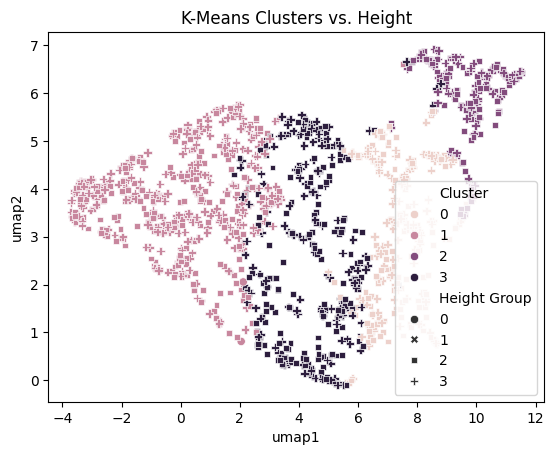

In [51]:
height_cluster_labels = display_metadata_clusters(height_y_test, height_embeddings, height_bucket_intervals)

c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


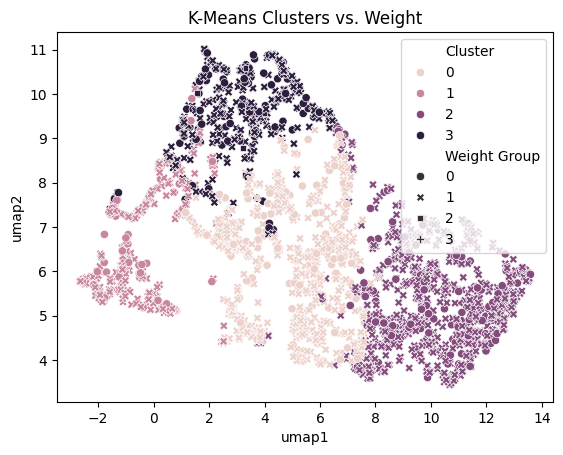

In [52]:
weight_cluster_labels = display_metadata_clusters(weight_y_test, weight_embeddings, weight_bucket_intervals)

### Evaluating Metadata Clustering Accuracy:

In [53]:
def get_metadata_cluster_accuracy(test_labels: pd.DataFrame | pd.Series, cluster_labels: np.ndarray) -> float:
    '''
    Determines the accuracy between the ground truth labels and the assigned cluster labels using linear sum assignment.
    The best cluster-class pair are computed and stored in a dictionary with the following format: {cluster_label : class_label}.
    This dictionary mapping is then used to return the accuracy score.
    
    Args:
        test_labels: The ground truth labels corresponding to the testing/validation set
        cluster_labels: The labels generated from clustering the data points within the testing set
        
    Returns:
        float: A float value reflecting the accuracy between the ground truth labels and cluster labels
    '''
    # Computing the confusion matrix
    conf_matrix = confusion_matrix(test_labels, cluster_labels, labels=np.unique(test_labels))
    print((f'Confusion Matrix:\n{conf_matrix}'))
    
    # Maximizing number of correct matches between a particular cluster and class 
    row_idx, col_idx = linear_sum_assignment(conf_matrix, maximize=True)
    label_mapping = {cluster: label for cluster, label in zip(col_idx, row_idx)}
    print(f'\nLabel Mapping:\n{label_mapping}')
    
    # Mapping clusters to labels (handles missing clusters)
    mapped_pred = [label_mapping.get(cluster, -1) for cluster in cluster_labels]
    mapped_pred = np.asarray(mapped_pred)
    
    # Computing accuracy (Ignoring -1s if necessary)
    mask = np.array(mapped_pred) != -1
    accuracy = accuracy_score(np.array(test_labels[mask]), np.array(mapped_pred[mask]))
    
    print(f'\nClustering Accuracy: {accuracy:.2%}')
    return accuracy

In [54]:
age_cluster_accuracy = get_metadata_cluster_accuracy(age_y_test, age_cluster_labels)

Confusion Matrix:
[[  5   6  27 166]
 [ 54  71 229 566]
 [445 508 690 610]
 [369 316 178  64]]

Label Mapping:
{1: 0, 3: 1, 2: 2, 0: 3}

Clustering Accuracy: 37.89%


In [55]:
sex_cluster_accuracy = get_metadata_cluster_accuracy(sex_y_test, sex_cluster_labels)

Confusion Matrix:
[[1113 1111]
 [1024 1056]]

Label Mapping:
{0: 0, 1: 1}

Clustering Accuracy: 50.39%


In [56]:
height_cluster_accuracy = get_metadata_cluster_accuracy(height_y_test, height_cluster_labels)

Confusion Matrix:
[[  0   0   0]
 [147 100 213]
 [144  92 157]]

Label Mapping:
{1: 0, 2: 1, 0: 2}

Clustering Accuracy: 14.48%


In [58]:
weight_cluster_accuracy = get_metadata_cluster_accuracy(weight_y_test, weight_cluster_labels)

Confusion Matrix:
[[133  79 187 122]
 [496 232 631 275]
 [  3   3   1   6]
 [  0   0   0   1]]

Label Mapping:
{0: 0, 2: 1, 3: 2, 1: 3}

Clustering Accuracy: 35.50%


### Generating Metadata-Specifc Probing Classifiers:

In [59]:
def generate_probing_classifier(model: keras.Sequential, x_train: pd.DataFrame | np.ndarray, x_test: pd.DataFrame | np.ndarray, n_classes: int, layer_to_probe: str | int=-2) -> tuple[keras.Sequential, np.ndarray, np.ndarray]:
    '''
    Generates a probing classifier based off the model provided. Training and testing features are created by utilizing an intermediate
    model to generate predictions. These features are then returned and can then be used to train/fit the compiled classifier.
    
    Args:
        model: The pre-trained model that will be analyzed
        x_train: The training data used for the original model
        x_test: The testing/validation data used for the original model
        n_classes: The number of unique classes/labels
        layer_to_probe: The layer from the original model to probe (defaults to the penultimate layer)
    
    Returns:
        tuple: A three-element tuple containing the compiled probing classifier, its training features, and its testing features
    '''
    # Freezing the model
    model.trainable = False
    
    # Defining the input and ouput layer for a smaller, intermediate model
    input_layer = model.layers[0].input
    
    if isinstance(layer_to_probe, str):
        output_layer = model.get_layer(layer_to_probe).output
    else:
        output_layer = model.get_layer(index=layer_to_probe).output
        
    # Building the intermediate model
    intermediate_model = Model(inputs=input_layer, outputs=output_layer)
    
    # Retrieving the feature embeddings for both training and validations sets
    train_features = intermediate_model.predict(x_train)
    test_features = intermediate_model.predict(x_test)
    
    if n_classes == 2:
        # Defining the probe classifier's architecture
        probe_classifier = Sequential([Input(shape=(train_features.shape[1],)),
                                       Dense(1, activation='sigmoid')])
        
        # Compiling the classifier
        probe_classifier.compile(loss = keras.losses.BinaryCrossentropy(),
                                 optimizer = keras.optimizers.Adam(learning_rate=0.0005),
                                 metrics = [keras.metrics.BinaryAccuracy(name='Accuracy'),
                                            keras.metrics.Recall(name='Recall'),
                                            keras.metrics.Precision(name='Precision'),
                                            keras.metrics.AUC(name='AUC')])
        
    elif n_classes > 2:
        # Defining the probe classifier's architecture
        probe_classifier = Sequential([Input(shape=(train_features.shape[1],)),
                                       Dense(n_classes, activation='softmax')])
        
        # Compiling the classifier
        probe_classifier.compile(loss = keras.losses.CategoricalCrossentropy(),
                                 optimizer = keras.optimizers.Adam(learning_rate=0.0005),
                                 metrics = [keras.metrics.CategoricalAccuracy(name='Accuracy'),
                                            keras.metrics.Recall(name='Recall'),
                                            keras.metrics.Precision(name='Precision'),
                                            keras.metrics.AUC(name='AUC')])
    
    return (probe_classifier, train_features, test_features)

In [60]:
age_classifier, age_train_features, age_test_features = generate_probing_classifier(
    model_1,
    x_train[age_train_mask],
    x_test[age_test_mask],
    n_classes=len(age_buckets)-1
)

534/534 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step


In [61]:
sex_classifier, sex_train_features, sex_test_features = generate_probing_classifier(
    model_1,
    x_train[sex_train_mask],
    x_test[sex_test_mask],
    n_classes=2
)

534/534 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step


In [62]:
height_classifier, height_train_features, height_test_features = generate_probing_classifier(
    model_1,
    x_train[height_train_mask],
    x_test[height_test_mask],
    n_classes=len(height_buckets)-1
)

173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


In [63]:
weight_classifier, weight_train_features, weight_test_features = generate_probing_classifier(
    model_1,
    x_train[weight_train_mask],
    x_test[weight_test_mask],
    n_classes=len(weight_buckets)-1
)

225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


### Training the Probing Classifiers:

In [64]:
def get_onehot_labels(train_labels: pd.Series, test_labels: pd.Series) -> tuple:
    '''
    Transforms the labels for both the training and testing datasets into one-hot binary matrices.
    
    Args:
        train_labels: The labels corresponding to the training dataset
        test_labels: The labels corresponding the the testing/validation dataset
        
    Returns:
        tuple: A two-element tuple containing: (y_train, y_test)
    '''
    label_binarizer = LabelBinarizer()
    
    # Encodes labels
    y_train = label_binarizer.fit_transform(train_labels)
    y_test = label_binarizer.transform(test_labels)
    
    # Preserving original index
    y_train = pd.DataFrame(data=y_train, index=train_labels.index)
    y_test = pd.DataFrame(data=y_test, index=test_labels.index)
    
    # Retrieving classes
    classes = label_binarizer.classes_
    
    return (y_train, y_test)

In [65]:
# Generating one-hot encoded labels for metadata sets
age_y_train_oh, age_y_test_oh = get_onehot_labels(age_y_train, age_y_test)
sex_y_train_oh, sex_y_test_oh = get_onehot_labels(sex_y_train, sex_y_test)
height_y_train_oh, height_y_test_oh = get_onehot_labels(height_y_train, height_y_test)
weight_y_train_oh, weight_y_test_oh = get_onehot_labels(weight_y_train, weight_y_test)

In [66]:
# Checkpoint folder
chkpt_folder = os.path.join(os.getcwd(), r'probe_training_sessions\session_1')
chkpt_folder

'c:\\Users\\loera\\Documents\\Multilabel-ECG-Classification\\probe_training_sessions\\session_1'

In [ ]:
def train_probe_classifier(probe_model: keras.Sequential, train_features: np.ndarray, train_labels: pd.Series | np.ndarray, test_features: np.ndarray, test_labels: pd.Series | np.ndarray, save_path: str, epochs: int=75) -> tuple:
    '''
    Trains a compiled classifier based on the training and testing features provided.
    
    Args:
        probe_model: A compiled probing classifier
        train_features: Feature embeddings to be used for training
        train_labels: Labels corresponding the training set
        test_features: Feature embeddings to be used for testing/validation
        test_labels: Labels corresponding to the testing set
        save_path: Location to save the probing classifier's best weights
        epochs: The number of epochs to train the classifier for
        
    Returns:
        tuple: A two-element tuple containing the training history of the classifier and the trained classifier itself
    '''
    # Defining checkpoint parameters
    probe_callbacks = [keras.callbacks.ModelCheckpoint(filepath=save_path,
                                                       monitor='val_Accuracy',
                                                       verbose=1,
                                                       save_best_only=True,
                                                       save_weights_only=True,
                                                       mode='max')]
    
    # Ensuring training and testing labels are in readable format
    train_labels = train_labels.astype('int32')
    test_labels = test_labels.astype('int32')
    
    # Training the classifier
    history = probe_model.fit(train_features,
                              train_labels,
                              epochs=epochs,
                              validation_data=(test_features, test_labels),
                              callbacks=probe_callbacks)
    
    return (history, probe_model)

In [68]:
# Defining save path
save_path = os.path.join(chkpt_folder, 'age', 'weights', 'Probing_Classfier_{epoch}.weights.h5')
os.makedirs(save_path, exist_ok=True)

# Training classifier on age metadata
age_history, age_classifier = train_probe_classifier(
    probe_model=age_classifier,
    train_features=age_train_features,
    train_labels=age_y_train_oh,
    test_features=age_test_features,
    test_labels=age_y_test_oh,
    save_path=save_path
)

Epoch 1/70
501/534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.7117 - Accuracy: 0.4412 - Precision: 0.4763 - Recall: 0.2427 - loss: 1.2768
Epoch 1: val_Accuracy improved from -inf to 0.54159, saving model to c:\Users\loera\Documents\Multilabel-ECG-Classification\probe_training_sessions\session_1\age\weights\Probing_Classfier_1.weights.h5
534/534 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7158 - Accuracy: 0.4459 - Precision: 0.4811 - Recall: 0.2465 - loss: 1.2665 - val_AUC: 0.8056 - val_Accuracy: 0.5416 - val_Precision: 0.5684 - val_Recall: 0.3204 - val_loss: 1.0286
Epoch 2/70
526/534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.8149 - Accuracy: 0.5655 - Precision: 0.6056 - Recall: 0.3795 - loss: 1.0107
Epoch 2: val_Accuracy improved from 0.54159 to 0.54322, saving model to c:\Users\loera\Documents\Multilabel-ECG-Classification\probe_training_sessions\session_1\age\weights\Probing_Classfier_2.weights.h5
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8150 - Accuracy: 0.5656 - Precision: 0.6

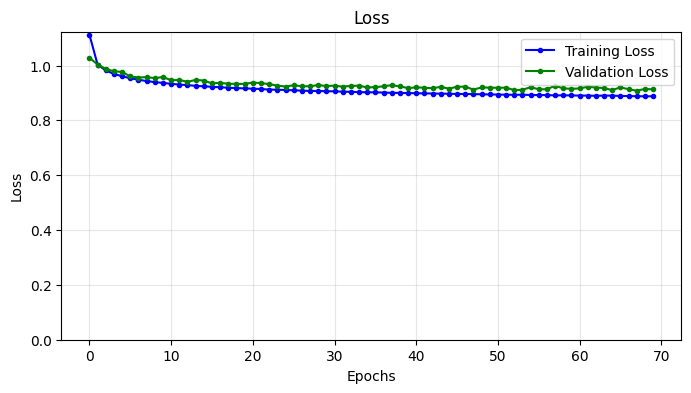

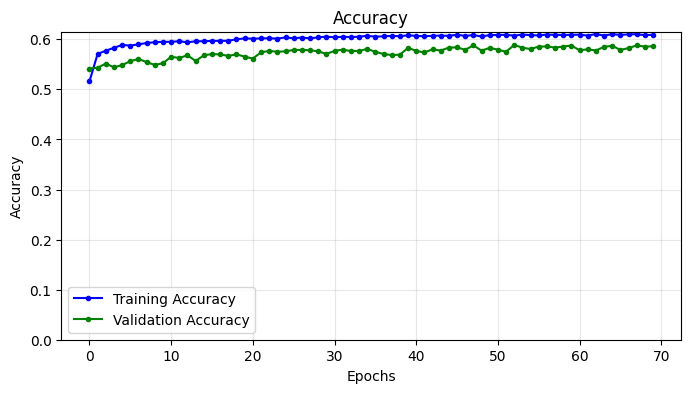

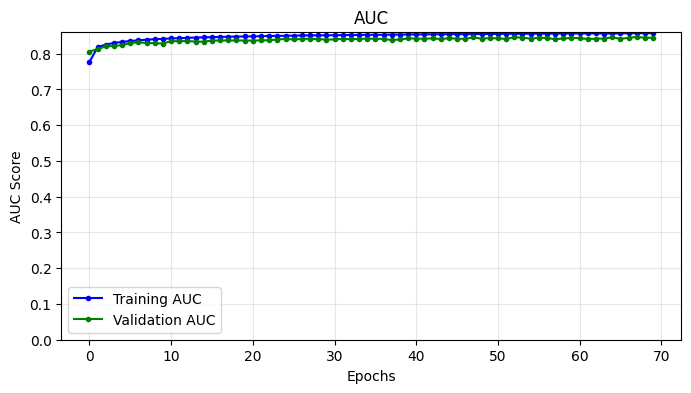

In [69]:
save_path = os.path.join(chkpt_folder, 'age')
plot_graphs(age_history, save_path=save_path)

In [70]:
# Defining save path
save_path = os.path.join(chkpt_folder, 'sex', 'weights', 'Probing_Classfier_{epoch}.weights.h5')
os.makedirs(save_path, exist_ok=True)

# Training classifier on sex metadata
sex_history, sex_classifier = train_probe_classifier(
    probe_model=sex_classifier,
    train_features=sex_train_features,
    train_labels=sex_y_train,
    test_features=sex_test_features,
    test_labels=sex_y_test,
    save_path=save_path
)

Epoch 1/70
492/534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.4919 - Accuracy: 0.5335 - Precision: 0.4674 - Recall: 0.2867 - loss: 0.7746
Epoch 1: val_Accuracy improved from -inf to 0.55785, saving model to c:\Users\loera\Documents\Multilabel-ECG-Classification\probe_training_sessions\session_1\sex\weights\Probing_Classfier_1.weights.h5
534/534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.4980 - Accuracy: 0.5360 - Precision: 0.4741 - Recall: 0.3041 - loss: 0.7692 - val_AUC: 0.5755 - val_Accuracy: 0.5579 - val_Precision: 0.5370 - val_Recall: 0.6168 - val_loss: 0.6904
Epoch 2/70
516/534 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.6397 - Accuracy: 0.6017 - Precision: 0.5750 - Recall: 0.6580 - loss: 0.6664
Epoch 2: val_Accuracy improved from 0.55785 to 0.57807, saving model to c:\Users\loera\Documents\Multilabel-ECG-Classification\probe_training_sessions\session_1\sex\weights\Probing_Classfier_2.weights.h5
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.6399 - Accuracy: 0.6018 - Precision: 0.5

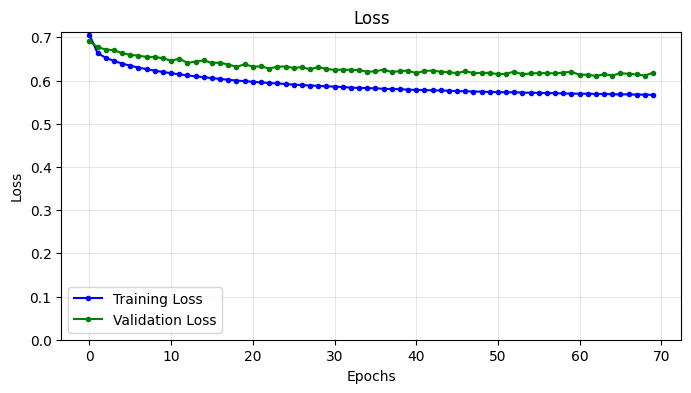

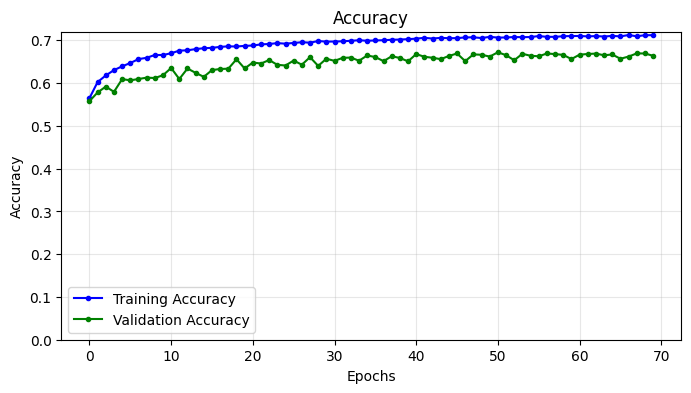

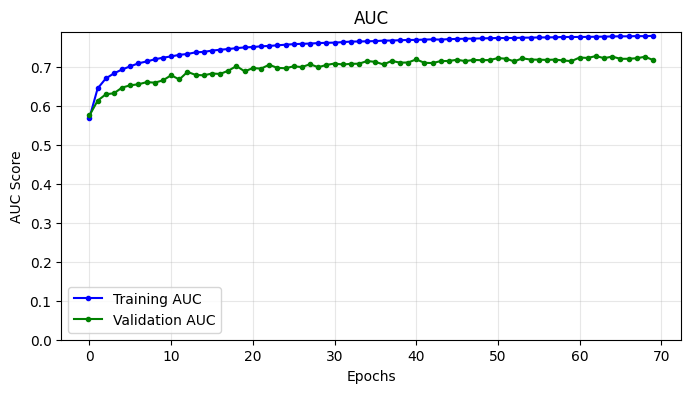

In [71]:
save_path = os.path.join(chkpt_folder, 'sex')
plot_graphs(sex_history, save_path=save_path)

In [72]:
# Defining save path
save_path = os.path.join(chkpt_folder, 'height', 'weights', 'Probing_Classfier_{epoch}.weights.h5')
os.makedirs(save_path, exist_ok=True)

# Training classifier on height metadata
height_history, height_classifier = train_probe_classifier(
    probe_model=height_classifier,
    train_features=height_train_features,
    train_labels=height_y_train_oh,
    test_features=height_test_features,
    test_labels=height_y_test_oh,
    save_path=save_path
)

Epoch 1/70
141/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.7863 - Accuracy: 0.4723 - Precision: 0.5154 - Recall: 0.2772 - loss: 1.0532  
Epoch 1: val_Accuracy improved from -inf to 0.58113, saving model to c:\Users\loera\Documents\Multilabel-ECG-Classification\probe_training_sessions\session_1\height\weights\Probing_Classfier_1.weights.h5
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7947 - Accuracy: 0.4768 - Precision: 0.5156 - Recall: 0.2868 - loss: 1.0217 - val_AUC: 0.8656 - val_Accuracy: 0.5811 - val_Precision: 0.5943 - val_Recall: 0.4932 - val_loss: 0.7289
Epoch 2/70
147/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.8526 - Accuracy: 0.5437 - Precision: 0.5490 - Recall: 0.4652 - loss: 0.7381
Epoch 2: val_Accuracy improved from 0.58113 to 0.59685, saving model to c:\Users\loera\Documents\Multilabel-ECG-Classification\probe_training_sessions\session_1\height\weights\Probing_Classfier_2.weights.h5
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8526 - Accuracy: 0.5440 - Precis

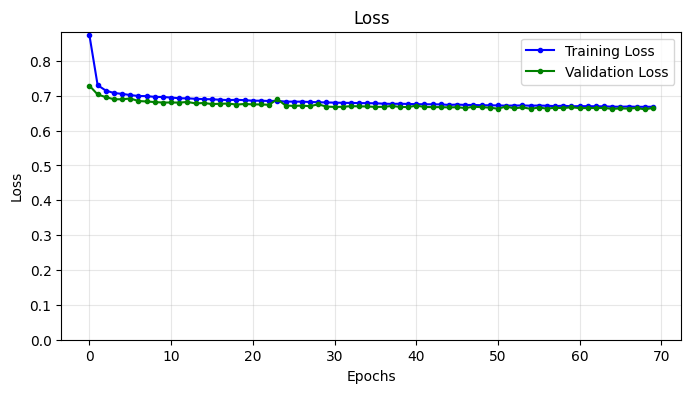

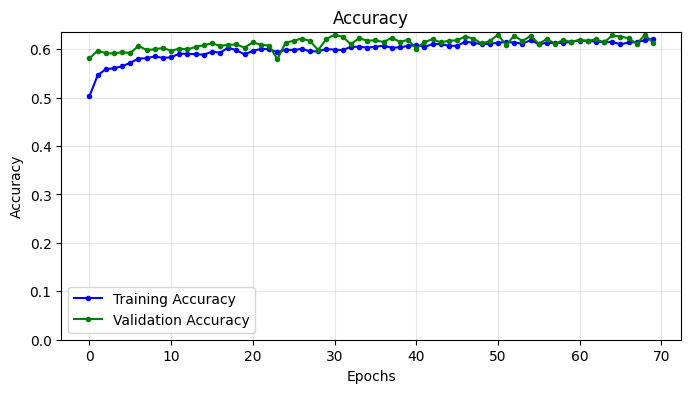

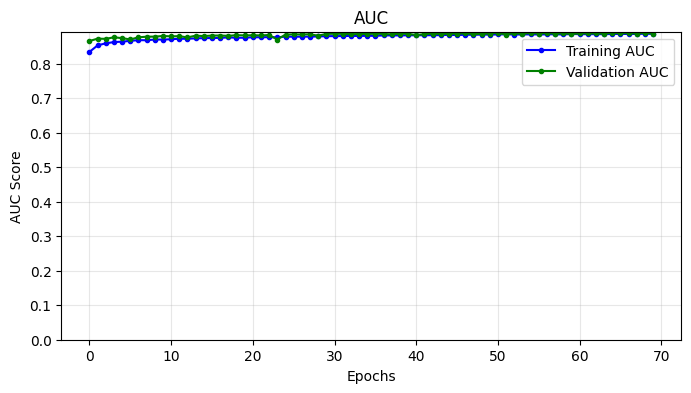

In [73]:
save_path = os.path.join(chkpt_folder, 'height')
plot_graphs(height_history, save_path=save_path)

In [74]:
# Defining save path
save_path = os.path.join(chkpt_folder, 'weight', 'weights', 'Probing_Classfier_{epoch}.weights.h5')
os.makedirs(save_path, exist_ok=True)

# Training classifier on weight metadata
weight_history, weight_classifier = train_probe_classifier(
    probe_model=weight_classifier,
    train_features=weight_train_features,
    train_labels=weight_y_train_oh,
    test_features=weight_test_features,
    test_labels=weight_y_test_oh,
    save_path=save_path
)

Epoch 1/70
209/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7580 - Accuracy: 0.4704 - Precision: 0.5335 - Recall: 0.2941 - loss: 1.0688   
Epoch 1: val_Accuracy improved from -inf to 0.75058, saving model to c:\Users\loera\Documents\Multilabel-ECG-Classification\probe_training_sessions\session_1\weight\weights\Probing_Classfier_1.weights.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7665 - Accuracy: 0.4825 - Precision: 0.5466 - Recall: 0.3107 - loss: 1.0504 - val_AUC: 0.9215 - val_Accuracy: 0.7506 - val_Precision: 0.7553 - val_Recall: 0.7229 - val_loss: 0.6165
Epoch 2/70
214/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.9055 - Accuracy: 0.7130 - Precision: 0.7176 - Recall: 0.6878 - loss: 0.6569
Epoch 2: val_Accuracy did not improve from 0.75058
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9056 - Accuracy: 0.7129 - Precision: 0.7176 - Recall: 0.6880 - loss: 0.6565 - val_AUC: 0.9249 - val_Accuracy: 0.7492 - val_Precision: 0.7521 - val_Recall: 0.7317 - val_loss: 0.5951
Epoch 

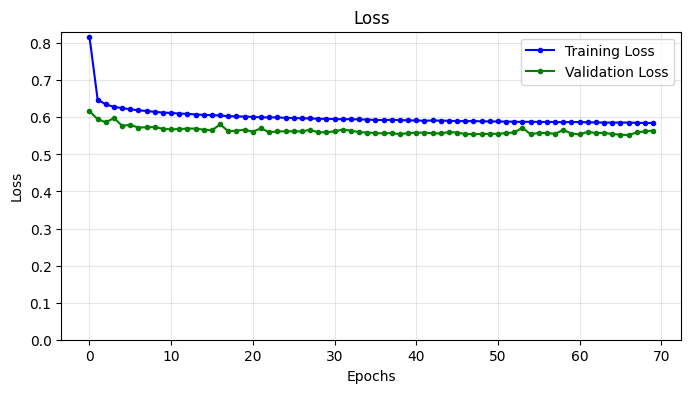

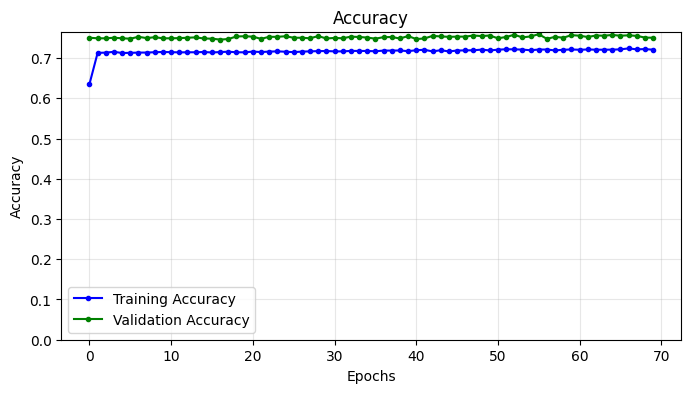

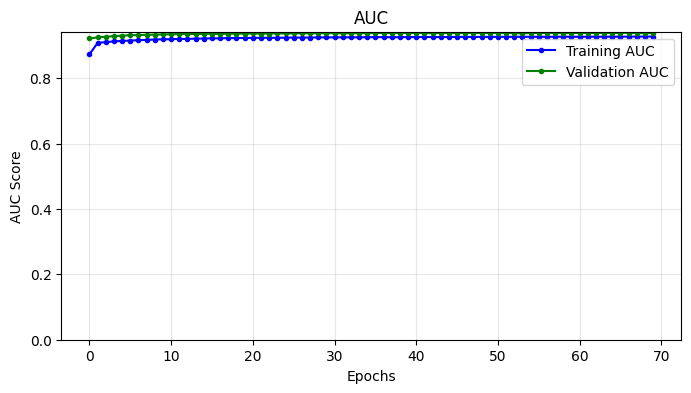

In [75]:
save_path = os.path.join(chkpt_folder, 'weight')
plot_graphs(weight_history, save_path=save_path)

### Evaluting Trained Probing CLassifers:

In [76]:
def get_probe_score(probe_model: keras.Sequential, test_features: np.ndarray, test_labels: pd.Series | np.ndarray) -> list:
    '''
    Returns the loss and accuracy scores of a trained probing classifier.
    
    Args:
        probe_model: The pre-trained probing classifier
        test_features: The feature embeddings used for testing/validation
        test_labels: The labels corresponding the test features
        
    Returns:
        list: A two-element list containing the loss and accuracy of the probing classifier
    '''
    # Ensuring testing labels are in readable format
    test_labels = test_labels.astype('int32')
    
    score = evaluate_model(probe_model, test_features, test_labels)
    return score

In [77]:
age_score = get_probe_score(age_classifier, age_test_features, age_y_test_oh)

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8429 - Accuracy: 0.5851 - Precision: 0.6088 - Recall: 0.4507 - loss: 0.9198

Loss on test data: 91.30%

Accuracy on test data: 58.62%


In [78]:
sex_score = get_probe_score(sex_classifier, sex_test_features, sex_y_test)

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7413 - Accuracy: 0.6797 - Precision: 0.6552 - Recall: 0.6791 - loss: 0.6011

Loss on test data: 61.85%

Accuracy on test data: 66.38%


In [79]:
height_score = get_probe_score(height_classifier, height_test_features, height_y_test_oh)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8773 - Accuracy: 0.5852 - Precision: 0.5877 - Recall: 0.5787 - loss: 0.6752

Loss on test data: 66.54%

Accuracy on test data: 61.33%


In [80]:
weight_score = get_probe_score(weight_classifier, weight_test_features, weight_y_test_oh)

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9402 - Accuracy: 0.7593 - Precision: 0.7598 - Recall: 0.7569 - loss: 0.5612

Loss on test data: 56.41%

Accuracy on test data: 75.06%


### Computing Classifcation Reports on Probing Classifiers:

In [82]:
# Loading the best weights for each feature-specific classifier
age_classifier.load_weights(r'probe_training_sessions\session_1\age\weights\Probing_Classfier_53.weights.h5')

sex_classifier.load_weights(r'probe_training_sessions\session_1\sex\weights\Probing_Classfier_51.weights.h5')

height_classifier.load_weights(r'probe_training_sessions\session_1\height\weights\Probing_Classfier_31.weights.h5')

weight_classifier.load_weights(r'probe_training_sessions\session_1\weight\weights\Probing_Classfier_56.weights.h5')

In [83]:
# Generating predictions for age groups
age_probe_pred = age_classifier.predict(age_test_features)
age_probe_pred = np.argmax(age_probe_pred, axis=1)
print('\nPredictions:\n', age_probe_pred)

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Predictions:
 [1 1 1 ... 2 1 2]


In [84]:
age_acc = accuracy_score(age_y_test, age_probe_pred)
print(f'Age Accuracy Score: {age_acc:.2%}\n')
print('Classification Report:\n\n', classification_report(age_y_test, age_probe_pred))

Age Accuracy Score: 58.88%

Classification Report:

               precision    recall  f1-score   support

           0       0.55      0.13      0.21       204
           1       0.55      0.40      0.46       920
           2       0.60      0.88      0.71      2253
           3       0.58      0.16      0.26       927

    accuracy                           0.59      4304
   macro avg       0.57      0.39      0.41      4304
weighted avg       0.58      0.59      0.54      4304



In [85]:
# Generating predictions for sex groups
sex_probe_pred = sex_classifier.predict(sex_test_features)
sex_probe_pred = (sex_probe_pred >= 0.5).astype(int).flatten()
print('\nPredictions:\n', sex_probe_pred)

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step

Predictions:
 [0 0 1 ... 0 1 0]


In [86]:
sex_acc = accuracy_score(sex_y_test, sex_probe_pred)
print(f'Sex Accuracy Score: {sex_acc:.2%}\n')
print('Classification Report:\n\n', classification_report(sex_y_test, sex_probe_pred, target_names=['Male', 'Female']))

Sex Accuracy Score: 67.19%

Classification Report:

               precision    recall  f1-score   support

        Male       0.67      0.74      0.70      2224
      Female       0.68      0.60      0.64      2080

    accuracy                           0.67      4304
   macro avg       0.67      0.67      0.67      4304
weighted avg       0.67      0.67      0.67      4304



In [92]:
# Generating predictions for height groups
height_probe_pred = height_classifier.predict(height_test_features)
height_probe_pred = np.argmax(height_probe_pred, axis=1)
print('\nPredictions:\n', height_probe_pred)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Predictions:
 [2 2 3 ... 2 3 2]


In [93]:
height_acc = accuracy_score(height_y_test, height_probe_pred)
print(f'Height Accuracy Score: {height_acc:.2%}\n')
print('Classification Report:\n\n', classification_report(height_y_test, height_probe_pred))

Height Accuracy Score: 62.97%

Classification Report:

               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           2       0.62      0.69      0.65       706
           3       0.64      0.57      0.60       691

    accuracy                           0.63      1399
   macro avg       0.42      0.42      0.42      1399
weighted avg       0.63      0.63      0.63      1399



c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [89]:
# Generating predictions for weight groups
weight_probe_pred = weight_classifier.predict(weight_test_features)
weight_probe_pred = np.argmax(weight_probe_pred, axis=1)
print('\nPredictions:\n', weight_probe_pred)

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Predictions:
 [1 1 1 ... 1 1 1]


In [90]:
weight_acc = accuracy_score(weight_y_test, weight_probe_pred)
print(f'Weight Accuracy Score: {weight_acc:.2%}\n')
print('Classification Report:\n\n', classification_report(weight_y_test, weight_probe_pred))

Weight Accuracy Score: 75.93%

Classification Report:

               precision    recall  f1-score   support

           0       0.58      0.09      0.15       521
           1       0.77      0.98      0.86      1634
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         1

    accuracy                           0.76      2169
   macro avg       0.34      0.27      0.25      2169
weighted avg       0.72      0.76      0.68      2169



c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo